In [1]:
using MGVInference
using Distributions
using Random
using ValueShapes
using LinearAlgebra
using Plots

In [2]:
param_size = 5

x1_grid = [Float64(i) for i in 1:25]
x2_grid = [i + 0.5 for i in 1:15]
common_grid = sort(vcat(x1_grid, x2_grid))

function line(x_grid, p)
    p[1]*10 .+ p[2] .* x_grid .+ p[3] .* x_grid.^2/5. .+ p[4] .* x_grid.^3/10.
end

function full_model(p)
    dist1 = Product(Normal.(line(x1_grid, p), p[5]^2*20))
    dist2 = Product(Normal.(line(x2_grid, p), p[5]^2*20))
    NamedTupleDist(a=dist1,
                   b=dist2)
end

full_model (generic function with 1 method)

In [16]:
true_params = randn(param_size); true_params[5] = abs(true_params[5])
display(true_params)
data = rand(full_model(true_params), 1)[1]
starting_point = randn(param_size)
display(starting_point)

5-element Array{Float64,1}:
 -0.2503114312999526
  1.1494814692738238
 -0.37486953715873667
 -0.9012840813587097
  1.5157908047655775

5-element Array{Float64,1}:
 -0.8865873995828082
  0.7699549622078672
  1.7289384642084382
 -0.007789871754357
 -0.5615128671150522

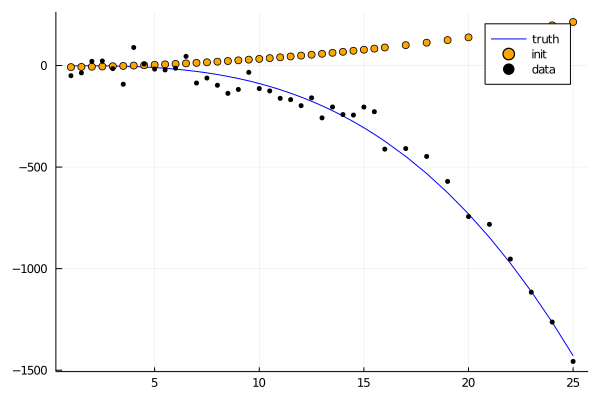

In [17]:
init_plots =() -> let
    truth = line(common_grid, true_params)
    plot!(common_grid, truth, markercolor=:blue, linecolor=:blue, label="truth")
    scatter!(common_grid, line(common_grid, starting_point), markercolor=:orange, label="init")
    scatter!(vcat(x1_grid, x2_grid), MGVInference.unshaped(data), markercolor=:black, markersize=3, label="data")
end
plot()
init_plots()

In [18]:
first_iteration = mgvi_kl_optimize_step(full_model, data, starting_point)
next_iteration = first_iteration

display(hcat(first_iteration, true_params))

5×2 Array{Float64,2}:
   2.85954  -0.250311
 -18.6595    1.14948
  10.1688   -0.37487
  -1.4559   -0.901284
  -0.55709   1.51579

5×5 Symmetric{Float64,Array{Float64,2}}:
  0.0782791   -0.160455    0.0485908   -0.00181188   0.0
 -0.160455     0.590375   -0.259346     0.0127048    0.0
  0.0485908   -0.259346    0.138051    -0.00758085   0.0
 -0.00181188   0.0127048  -0.00758085   0.000444949  0.0
  0.0          0.0         0.0          0.0          0.130026

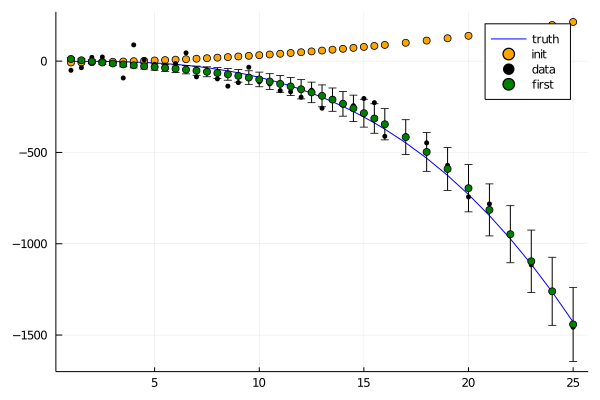

In [19]:
plot_iteration = (params, label) -> let
    error_mat = mgvi_kl_errors(full_model, params)
    display(error_mat)
    errors = sqrt.(error_mat[diagind(error_mat)])
    yerr = abs.(line(common_grid, params+errors) - line(common_grid, params-errors))
    scatter!(common_grid, line(common_grid, params), markercolor=:green, label=label, yerr=yerr)
end
    
plot()
init_plots()
plot_iteration(first_iteration, "first")

In [20]:
plot_iteration_light = (params, counter) -> let
    scatter!(common_grid, line(common_grid, params), markercolor=:green, markersize=3, markeralpha=2*atan(counter/18)/π, label=nothing)
end

#19 (generic function with 1 method)

5×2 Array{Float64,2}:
  0.0146868  -0.250311
  0.217383    1.14948
  0.556787   -0.37487
 -0.959667   -0.901284
 -2.97729     1.51579

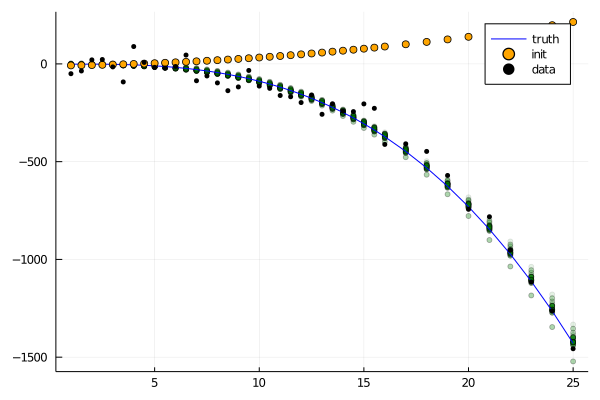

In [21]:
plt = scatter()
for i in 1:20
    next_iteration = mgvi_kl_optimize_step(full_model, data, next_iteration)
    plot_iteration_light(next_iteration, i)
end
display(hcat(next_iteration, true_params))

init_plots()
display(plt)

5×5 Symmetric{Float64,Array{Float64,2}}:
  0.930995    -0.0452752  -0.0600366  -0.00428853  0.0
 -0.0452752    0.960568   -0.0607661  -0.0156198   0.0
 -0.0600366   -0.0607661   0.895764   -0.0814852   0.0
 -0.00428853  -0.0156198  -0.0814852   0.011029    0.0
  0.0          0.0         0.0         0.0         0.999713

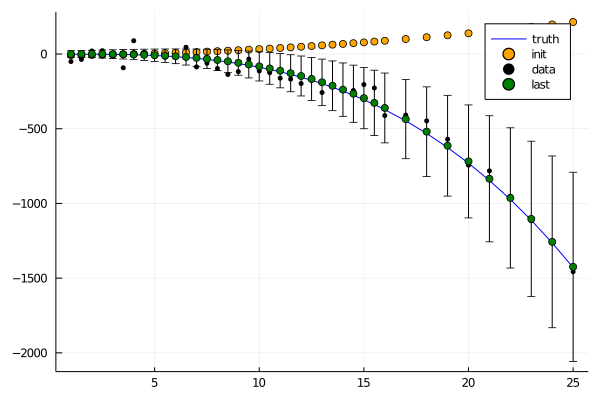

In [22]:
plot()
init_plots()
plot_iteration(next_iteration, "last")